<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](git@github.com:ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [5.0 Regression Approximations to Estimate Sensitivities](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.00-Regression-Approximations-to-Estimate-Sensitivities.html) | [Contents](toc.html) | [5.2 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/05.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 5.1 Chapter 5 - Ridge Regression

Created by Ben Whewell (bwhewell@nd.edu)

This example was adapted from:

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 4: Local Sensitivity Analysis Based on Derivative Approximations, Springer, https://doi.org/10.1007/978-3-319-99525-0_4

In [1]:
## import all needed Python libraries here
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

In [2]:
# Functions to be used Later
np.random.seed(47)
# Train/Test Split
def tt_split(x,y,size):
    inds = np.arange(len(x))
    np.random.shuffle(inds)  
    split = int(np.ceil(len(x)*size))
    # x_train, x_test, y_train, y_test
    return x[inds[split:]],x[inds[:split]],y[inds[split:]],y[inds[:split]]

# Mean Squared Error
def mse(y,y_hat):
    return np.mean((y-y_hat)**2)

## 5.1.1 Sensitivities with Least-Squares Regression
QoI $Q(x)$ where $\mathbf{x} = (x_1, ..., x_J)^T$ of $J$ parameters. 
$I$ Equations that relate the known values of $Q_i$ and $\mathbf{x}_i$ to the unknown sensitivities.

$X_{ij} = (x_{ij} - \bar{x}_j) \quad$ 
$\mathbf{y} = \begin{pmatrix} Q_1 - Q(\mathbf{\bar{x}}) \\ Q_2 - Q(\mathbf{\bar{x}})\\  ... \\ Q_I - Q(\mathbf{\bar{x}}) \end{pmatrix} \quad $ $\beta = \begin{pmatrix} \left.\frac{\partial Q}{\partial x_1}\right|_\mathbf{\bar{x}} \\ \left.\frac{\partial Q}{\partial x_2}\right|_\mathbf{\bar{x}} \\ ... \\ \left.\frac{\partial Q}{\partial x_J}\right|_\mathbf{\bar{x}} \end{pmatrix}$

This can be rearranged into $\mathbf{X\beta} = \mathbf{y}$, which is similar to a Least Squares problem when $I > J$ and where $\hat{\beta}_{LS} = \left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y}$.


## 5.1.2 Ridge Regression
#### Normalize the Data

$X_{ij} = \frac{(x_{ij} - \bar{x}_j)}{\bar{x}_j} \quad$ 
$\beta = \begin{pmatrix} \left.\bar{x}_1\frac{\partial Q}{\partial x_1}\right|_\mathbf{\bar{x}} \\ \left.\bar{x}_2\frac{\partial Q}{\partial x_2}\right|_\mathbf{\bar{x}} \\ ... \\ \left.\bar{x}_J\frac{\partial Q}{\partial x_J}\right|_\mathbf{\bar{x}} \end{pmatrix}$

Ridge regression adds the $\ell_2$ penalty to the $\beta$ minimization problem. This tries to minimize the resulting $\beta$ vector.
\begin{equation}
\hat{\beta}_{\text{ridge}} = \min_{\beta} \sum_{i =1}^{I} (y_i - \beta \cdot \mathbf{x}_i)^2 + \lambda \beta||_2 \quad \\ ||\beta||_2 = \left(\sum_{i=1}^{I}|\beta_i|^2\right)^{1/2} 
\end{equation}

\begin{equation}
\hat{\beta}_{\text{ridge}} = \left(\mathbf{X}^T\mathbf{X} +\lambda \mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y}
\end{equation}


In [3]:
# Ridge Regression
def ridge_model(x_train,y_train,Lambda,x_test,coef_=False):
    beta = np.linalg.inv(x_train.T @ x_train + Lambda *np.eye(x_train.shape[1])) @ x_train.T @ y_train
    if coef_:
        return beta
    return x_test @ beta

## 5.1.3 Cross Validation
$\lambda$ is a hyperparameter that needs to be optimized through cross validation. 

#### Process for CV
1. Select number of folds ($K$-folds)
2. Select $\lambda = (\lambda_1, ... ,\lambda_L)$ values
3. $\texttt{For k in folds:}$ \\
  $\qquad \texttt{Randomly sample data leaving $1/k$ of data as testing}$ \\
  $ \qquad \texttt{for jj in $\lambda$:}$ \\
  $ \qquad \qquad \texttt{Calculate $\hat{y}$ of Ridge Regression} $ \\
  $ \qquad \qquad \texttt{Calculate MSE between $\hat{y}$ and $y$} $
4. A matrix of size $k$-folds $\times$ $\lambda$ averages the $\lambda$ across the folds
5. The largest $\lambda$ value is chosen that is still within one standard error of the smallest mean MSE.



In [4]:
# Cross Validation
def cross_validation(x,y,Lambda,k_folds):
    # Error matrix
    error = np.zeros((k_folds,len(Lambda)))
    for ii in range(k_folds):
        # Resample the training and testing data
        x_train,x_test,y_train,y_test = tt_split(x,y,1/k_folds)
        for jj in range(len(Lambda)):
            # Fit Model to Different Lambda values
            y_hat = ridge_model(x_train,y_train,Lambda[jj],x_test)
            # Calculate MSE 
            error[ii,jj] = mse(y_test,y_hat)
    return best_lambda(error,Lambda)
    
# Calculating Optimal lambda for Ridge Regression
def best_lambda(error,Lambda):
    # Maximum lambda within 1 standard error of minimum of mean MSE
    bound = np.min(np.mean(error,axis=0))+np.std(error)/np.sqrt(k_folds*len(Lambda)) 
    means = np.mean(error,axis=0)
    best = Lambda[0] # initialize 
    for ii in range(len(Lambda)):
        if (bound - means[ii]) > 0 and Lambda[ii] > best:
            best = Lambda[ii]
    # return Lambda[np.argmin(means)] # minimum MSE
    return best


## 5.1.4 Example Problem
#### I > J 

In [5]:
np.random.seed(47)
# I > J (Least Squares Problem, I = 506, J = 13)
X,Y = load_boston(return_X_y=True)
# Normalize Data - Dimensionless
Y = Y - np.mean(Y)
X = (X - np.mean(X,axis=0))/np.mean(X,axis=0)
# Search different lambdas
Lambdas = [0.01,0.1,0.15,0.2,0.5,1,10,20]
k_folds = len(X) # Leave one out validation
# Calculating Optimal Lambda
param_ = cross_validation(X,Y,Lambdas,k_folds=k_folds)
# Train/Test split (20% Testing)
x_train,x_test,y_train,y_test = tt_split(X,Y,0.2)
# Calculate coefficients in Ridge Regression
beta_1 = ridge_model(x_train,y_train,param_,x_test,coef_=True)

#### 5.1.4.1 I < J 

In [6]:
np.random.seed(47)
# I < J (Estimating Local Sensitivities, I = 10, J = 13)
X,Y = load_boston(return_X_y=True)
# Randomly Chose 10 simulations
inds = np.random.choice(range(0,len(X)),10)
x = X[inds]; y = Y[inds]
# Normalize Data - Dimensionless
y = y-np.mean(y)
x = (x - np.mean(x,axis=0))/np.mean(x,axis=0)
# Search different lambdas
Lambdas = [0.01,0.1,0.15,0.2,0.5,1,10,20]
k_folds = len(x) # Leave one out validation
# Calculating Optimal Lambda
param_ = cross_validation(X,Y,Lambdas,k_folds=k_folds)
# Train/Test split (20% Testing)
x_train,x_test,y_train,y_test = tt_split(x,y,0.2)
# Calculate coefficients in Ridge Regression
beta_2 = ridge_model(x_train,y_train,param_,x_test,coef_=True)

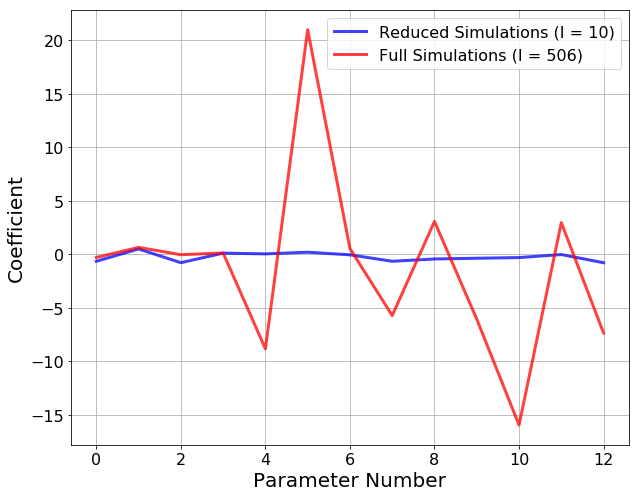

In [7]:
plt.figure(figsize=(10,8))
plt.plot(beta_2,label='Reduced Simulations (I = 10)',c='b',alpha=0.75,lw=3)
plt.plot(beta_1,label='Full Simulations (I = 506)',c='r',alpha=0.75,lw=3)
plt.grid(); plt.legend(loc='best',prop={'size':16})
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Coefficient',fontsize=20); plt.xlabel('Parameter Number',fontsize=20)
plt.show()

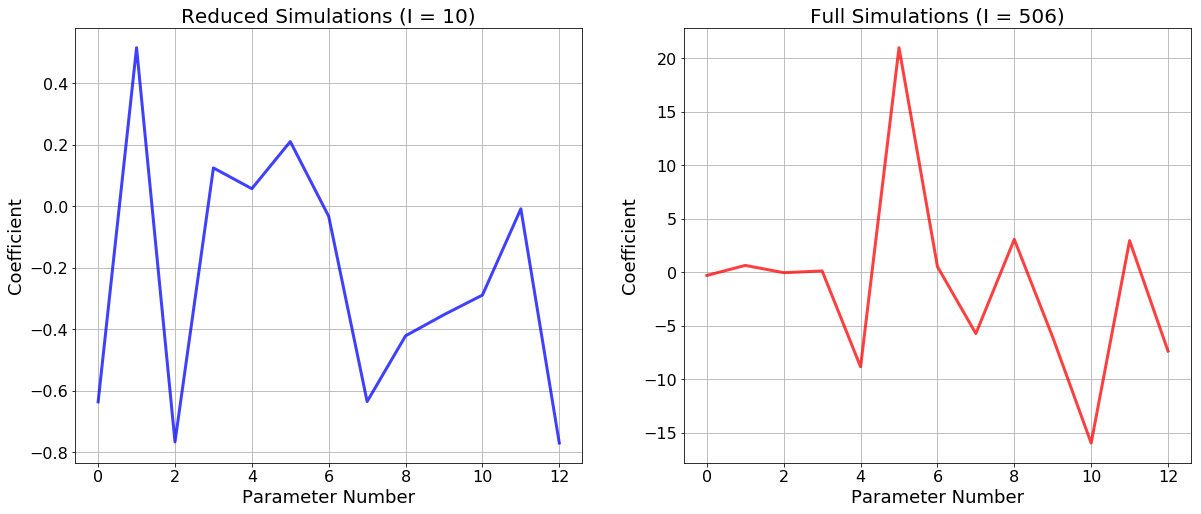

In [8]:
fig = plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(beta_2,c='b',alpha=0.75,lw=3)
plt.title('Reduced Simulations (I = 10)',fontsize=20); plt.grid()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Coefficient',fontsize=18); plt.xlabel('Parameter Number',fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(beta_1,c='r',alpha=0.75,lw=3)
plt.title('Full Simulations (I = 506)',fontsize=20); plt.grid()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Coefficient',fontsize=18); plt.xlabel('Parameter Number',fontsize=18)

plt.show()

## 5.1.5 Ridge Regression with SKLearn

In [9]:
X,Y = load_boston(return_X_y=True)
Lambdas = [0.01,0.1,0.15,0.2,0.5,1,10,20]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
k_folds = 25
ridge = RidgeCV(alphas=Lambdas,cv=k_folds,normalize=False)
regression = ridge.fit(x_train,y_train)
y_hat = regression.predict(x_test)
beta_sklearn = regression.coef_

<!--NAVIGATION-->
< [5.0 Regression Approximations to Estimate Sensitivities](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.00-Regression-Approximations-to-Estimate-Sensitivities.html) | [Contents](toc.html) | [5.2 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/05.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>